<a href="https://colab.research.google.com/github/inbarhub/YDATA_DL_assignments_2021-2022/blob/main/H.W_9_Text_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN for text generation


In this exercise, I've created a metal lyrics generator. Rock on.

## RNN for Text Generation


In [ ]:
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from torchsummary import summary
from sklearn import preprocessing
import matplotlib.pyplot as plt
import random
import torch.utils.data as data
from wakepy import set_keepawake, unset_keepawake

### data preprocessing

In [ ]:
path="C:/Users/user/Documents/Ydata/Ex 8 generating songs/english_cleaned_lyrics/"


In [ ]:
df=pd.read_csv(f"{path}english_cleaned_lyrics.csv")

In [ ]:
df=df[df['genre']=='Metal']

In [ ]:
df.head()

,Unnamed: 0,index,song,year,artist,genre,lyrics
331,415,415,northern-hymn,2011,demonaz,Metal,Gods Of The Mountains Sky Forest And Seas Land...
332,416,416,under-the-great-fires,2011,demonaz,Metal,Rise gods of the fierous black burning skies R...
333,417,417,all-blackened-sky,2011,demonaz,Metal,A Dying Skyline Cold From Wind And Rain Autumn...
334,418,418,legends-of-fire-and-ice,2011,demonaz,Metal,Fiends of the gods to war we ride Over the bla...
335,419,419,ode-to-battle,2011,demonaz,Metal,Cold Is The Winter On Its Ground We Ride To Th...


In [ ]:
lyrics=np.array(df.lyrics)

In [ ]:
chars=[]
for song in lyrics:
  for c in song:
    chars.append(c.lower())
  chars.append('[end]')


In [ ]:
# make set of all characters
collection=list(set(chars))


In [ ]:
corpuslength=len(chars[0:100000])
corpuslength

100000

In [ ]:
#char dictionaries

int2char = dict(enumerate(collection))
char2int = {ch: ii for ii, ch in int2char.items()}

In [ ]:
char2int['[end]']

33

In [ ]:
N_LETTERS=len(int2char)
N_LETTERS

51

In [ ]:
# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(N_LETTERS)
    tensor[char2int[letter]] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][char2int[letter]] = 1
    return tensor


In [ ]:
window = 20
X_train = torch.zeros(corpuslength-window,  window , N_LETTERS)
y_train = torch.zeros(corpuslength-window, N_LETTERS)

for i in range(0, corpuslength - window):
    input = chars[i:i + window]
    X_train[i]=line_to_tensor(input)

    true = chars[i + window]
    y_train[i]=letter_to_tensor(true)




In [ ]:
X_train.shape

torch.Size([99980, 20, 51])

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Model and forward pass

In [ ]:
class CharRNN(nn.Module):
    def __init__(self, tokens=51, hidden_size=256 ,layers=2 ,batchsize=128 ):
        super(CharRNN, self).__init__()
        self.layers=layers
        self.hiddensize=hidden_size
        self.lstm=nn.LSTM(input_size=tokens, hidden_size = hidden_size, num_layers =layers, batch_first=True,bidirectional =False
                          ,dropout=0.1)
        #X = batch x seq x input. batch x 1 x N_letters (one hot per letter)
        self.batchsize=batchsize
        self.linear = nn.Linear(hidden_size, tokens)

    def forward(self, x, hidden, cell):
        x, (h,c) = self.lstm(x,(hidden, cell))
        # take only the last output
        if len(x.shape)==3:
          x = x[:, -1, :]
        else:
          x[-1, :]
        # produce output
        x = self.linear(x)
        return x, (h, c)
    def init_states(self, batchsize):
        # Initialize the initial hidden and cell states
        h0 = torch.randn((self.layers, batchsize, self.hiddensize)).to(device)
        c0 = torch.randn((self.layers, batchsize, self.hiddensize)).to(device)
        return (h0,c0)

In [ ]:
batch_size = 128
loader = data.DataLoader(data.TensorDataset(X_train[0:99968], y_train[0:99968]), shuffle=True, batch_size=batch_size)

In [ ]:
model = CharRNN().to(device)
(h,c) = model.init_states(batchsize=128)
x,y = next(iter(loader))
test,(h,c)=model(x.to(device), h, c)
test,test.shape

(tensor([[ 0.0062, -0.0352, -0.0001,  ...,  0.0097, -0.0054, -0.0108],
         [ 0.0036, -0.0326, -0.0009,  ...,  0.0092, -0.0064, -0.0099],
         [ 0.0069, -0.0351, -0.0021,  ...,  0.0078, -0.0057, -0.0098],
         ...,
         [ 0.0064, -0.0338,  0.0018,  ...,  0.0094, -0.0097, -0.0109],
         [ 0.0044, -0.0347,  0.0037,  ...,  0.0115, -0.0070, -0.0121],
         [ 0.0053, -0.0341, -0.0002,  ...,  0.0093, -0.0054, -0.0113]],
        grad_fn=<AddmmBackward0>),
 torch.Size([128, 51]))

In [ ]:

h.shape,c.shape,x.shape #input size: batch x seq length x "input size", 128 50 51
#hidden 1 x batch x hidden

(torch.Size([2, 128, 256]),
 torch.Size([2, 128, 256]),
 torch.Size([128, 20, 51]))

In [ ]:
loss_fn = nn.CrossEntropyLoss(reduction="sum")
loss_fn(test.to(device), y.to(device))

tensor(504.8995, grad_fn=<NegBackward0>)

In [ ]:
 def tensor_to_letter(output,temp=1):
    return int2char[ output.argmax().item()]


In [ ]:
def tensor_to_text(tensor):
  string=''
  for t in tensor:
    c=int2char[t.argmax().item()]
    string+=c
  return string


In [ ]:
temp=1
model.eval()

start,_ = next(iter(loader))
start = start[0]
endtensor=letter_to_tensor('[end]')
max_length=50

string='Prompt: " '  +  tensor_to_text(start) + '" '

with torch.no_grad():  # no need to track history in sampling
    hidden, cell = model.init_states(batchsize=1)
    hidden, cell = hidden[:,0,:],cell[:,0,:] #[3 x 256] (layers x hidden)

    input = start
    input.shape #20 x 51 seq x letters

    for i in range(3):
        output, (hidden , cell) = model(input.to(device) ,hidden,cell)
        output = nn.functional.softmax( output[-1].div(temp), dim=0 )
        output = torch.multinomial(output, 1)
        letter = int2char[output.item()]
        string=string+letter
        if letter == '[end]':
             break
        out=letter_to_tensor(letter)
        input = torch.cat((input.to(device),out.reshape(1,-1)),0)
        input = input[1:]
        print(string)


Prompt: "  anywhere so pretend" 
Prompt: "  anywhere so pretend" s
Prompt: "  anywhere so pretend" sw


In [ ]:
str='test'
l='g'
str=str+l
print(str)

testg


In [ ]:
def gen_text(temp=1,max_length=50):
    model.eval()

    start,_ = next(iter(loader))
    start = start[0]


    string='Prompt: " '  +  tensor_to_text(start) + '" '

    with torch.no_grad():  # no need to track history in sampling
        hidden, cell = model.init_states(batchsize=1)
        hidden, cell = hidden[:,0,:],cell[:,0,:] #[3 x 256] (layers x hidden)

        input = start
        input.shape #20 x 51 seq x letters

        for i in range(max_length):
            output, (hidden , cell) = model(input.to(device) ,hidden,cell)
            output = nn.functional.softmax( output[-1].div(temp), dim=0 )
            output = torch.multinomial(output, 1)
            letter = int2char[output.item()]
            string=string+letter
            if letter == '[end]':
                break
            out=letter_to_tensor(letter)
            input = torch.cat((input.to(device),out.reshape(1,-1)),0)
            input = input[1:]
    print(string)


In [ ]:
gen_text(temp=1)

Prompt: " et big solitude and " 1[nbnd[end]


In [ ]:
def train_model(model, criterion, optimizer, scheduler,num_epochs=5):
    since = time.time()
    train_res= []
    model.train()

    for epoch in range(num_epochs):
        epoch_loss=0
        (hidden,cell) = model.init_states(batchsize=128)

        for X_batch, y_batch in loader:
          with torch.set_grad_enabled(True):
              out, (hidden,cell) = model(X_batch.to(device), hidden, cell)
              loss = criterion(out, y_batch.to(device))
              loss.backward() # Perform a step in the opposite direction of the gradient
              optimizer.step() # Adapt the optimizer
              optimizer.zero_grad()
          hidden = hidden.detach()
          cell =  cell.detach()

          train_res.append(loss.item())
          epoch_loss += loss.item()

        scheduler.step()
        print(f'Loss: {epoch_loss}')

        gen_text(temp=1)

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')

    plt.plot(train_res)
    plt.title('Loss')
    plt.show()



    return model

model=CharRNN(tokens=N_LETTERS, hidden_size=256, layers=2, batchsize=128).to(device) #96 w categories?))

Loss: 210209.96389770508
Prompt: " war on the spineless"  we areree the wiser im you're me grfong to besith
Loss: 175607.49060058594
Prompt: " y four walls the ess" hsles tstta teenssngop uconnsiyonsnlatmu attruo'ko
Loss: 166243.44357299805
Prompt: " ade of stone holding"  fliars our worting but time i can saes menicgind 
Loss: 132008.59899139404
Prompt: " our eye focused this"  song our is the too leave ruttle and druggch you 
Loss: 121879.18506622314
Prompt: "  corrupted city was " sun a wandering the searching on your final brothe
Loss: 113290.77262878418
Prompt: " ses are longer some " sees colcaning we scace and blind on a difference 
Loss: 105971.80444335938
Prompt: " i need your approval"  stand beaten life change me back over fire to bre
Loss: 86879.03690719604
Prompt: "  the greed the lies " here do you're not ask the ashes into the houl sou
Loss: 78252.23818969727
Prompt: " st closed eyes bring"  that rathing the land dreams so i look upon bitch
Loss: 72996.79376983643
Prompt

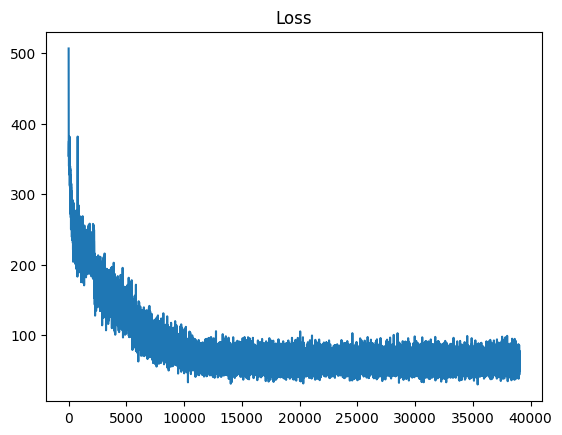

Prompt: " my bondage flesh and"  hurns of it's not ahoun there is the truth i feel my head by my own my foreshles [end]
Prompt: " getting fucking loos" e there is something commort the road that she world we rise march of the norse march of the norse and we are all i've been left beal ascends will we ever transcend and heavy is the shit eternity past before all set you were the plays after the reflection in front of me and only and you fool your mi


<function wakepy._win.unset_keepawake()>

In [ ]:


loss_fn = nn.CrossEntropyLoss(reduction="sum")

optimizer_ft =  optim.Adam(model.parameters(), lr=0.005) #optim.SGD(model.parameters(), lr=0.01, momentum=0.9) #

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 50

model = train_model(model,
                       loss_fn,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

gen_text(max_length = 300, temp=1)
gen_text(max_length = 300, temp=0.8)



In [ ]:
gen_text(temp=0.5)

Prompt: " ime that we've spent"  chasing dreams as the life with maggots writhing 


In [ ]:
gen_text(max_length = 300, temp=1)

Prompt: " e forgotten peace th" e way all their fathers fearless i'll deep viciousness hard for my body gates of tomorrow think of fainta the sword for they have to do is all you have to kil days of leaving leaves get sometimes i can you humps the dawn and you've earned it i close there in me[end]



---
#### This exericse was originally written by Dr. Omri Allouche.